# **0. 데이터 불러오기 및 전처리**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

url='/content/drive/MyDrive/dhata/프로젝트/vgames2.csv'
df=pd.read_csv(url, index_col=0).dropna().reset_index().drop('index',axis=1)

'Sales'를 포함하는 열에 대해 단위를 백만으로 통일하고, 모두 실수형으로 변환.

In [3]:
sales_cols=df.filter(regex='_Sales').columns
for col in sales_cols:
  df[col]=df[col].replace({' ': '', 'M': '', 'K': 'e-03'}, regex=True).astype(float) # 단위 설명

한자리~두자리수 연도를 네자리수로 변환하고 정수로 형변환.

In [4]:
def yearOutlier(x):
  if 0<=x<20:
    return int(2000+x) 
  elif 80<=x<100:
    return int(1900+x)
  else:
    return int(x)
df['Year']=df['Year'].apply(yearOutlier)

앞으로 수행할 분석을 위해 전세계 출고량 열을 생성하고 10년 단위로 데이터프레임을 분할.

In [5]:
df['Global_Sales']=df['NA_Sales']+df['EU_Sales']+df['JP_Sales']+df['Other_Sales'] # 전세계 출고량에 대한 간단한 특성 공학(feature engineering)

In [6]:
ydf1=df[(df['Year']>= 1980)&(df['Year']<1990)].reset_index(drop=True) # 80년대 출시 게임
ydf2=df[(df['Year']>= 1990)&(df['Year']<2000)].reset_index(drop=True) # 90년대 출시 게임
ydf3=df[(df['Year']>= 2000)&(df['Year']<2010)].reset_index(drop=True) # 2000년대 출시 게임
ydf4=df[(df['Year']>= 2010)].reset_index(drop=True) # 2010년대(2016년 이후는 자료 거의 없음)

# **1. 지역에 따라서 선호하는 게임 장르가 다른가**

In [7]:
df_GenReg=df.groupby('Genre').mean().drop('Year',axis=1)
# 지역에 따른 장르별 평균 출고량
df_GenReg_1=df.groupby('Genre').median().drop('Year',axis=1)
# 지역에 따른 장르별 출고량 중간값

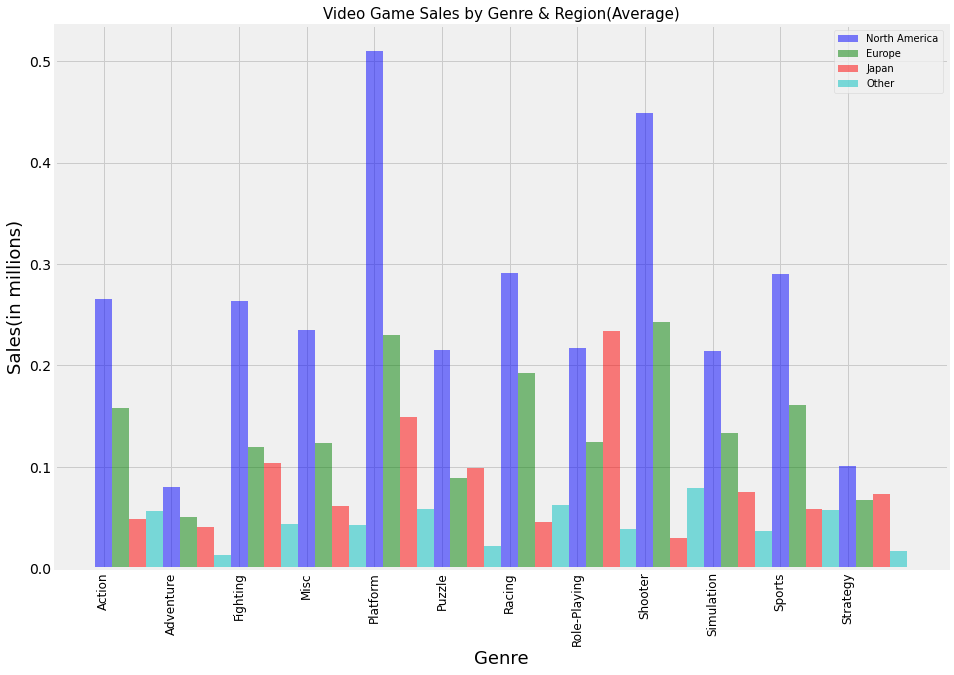

In [8]:
N=len(df_GenReg.index)
index=np.arange(N)
label=['Action', 'Adventure', 'Fighting','Misc', 'Platform','Puzzle', 'Racing',  
       'Role-Playing', 'Shooter', 'Simulation','Sports','Strategy']
bar_width = 0.25
alpha = 0.5
plt.figure(figsize=(16,10))
plt.style.use('fivethirtyeight')
p1 = plt.bar(index, df_GenReg['NA_Sales'], 
             bar_width, 
             color='b', 
             alpha=alpha,
             label='North America')
p2 = plt.bar(index+bar_width, df_GenReg['EU_Sales'], 
             bar_width, 
             color='g', 
             alpha=alpha,
             label='Europe')
p3 = plt.bar(index+bar_width*2, df_GenReg['JP_Sales'], 
             bar_width, 
             color='r', 
             alpha=alpha,
             label='Japan')
p4 = plt.bar(index+bar_width*3, df_GenReg['Other_Sales'], 
             bar_width, 
             color='c', 
             alpha=alpha,
             label='Other')

plt.title('Video Game Sales by Genre & Region(Average)', fontsize=15)
plt.ylabel('Sales(in millions)', fontsize=18)
plt.xlabel('Genre', fontsize=18)
plt.xticks(index, label, fontsize=12, 
           rotation=90)
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('North America', 'Europe', 'Japan', 'Other'), fontsize=10)
plt.show()

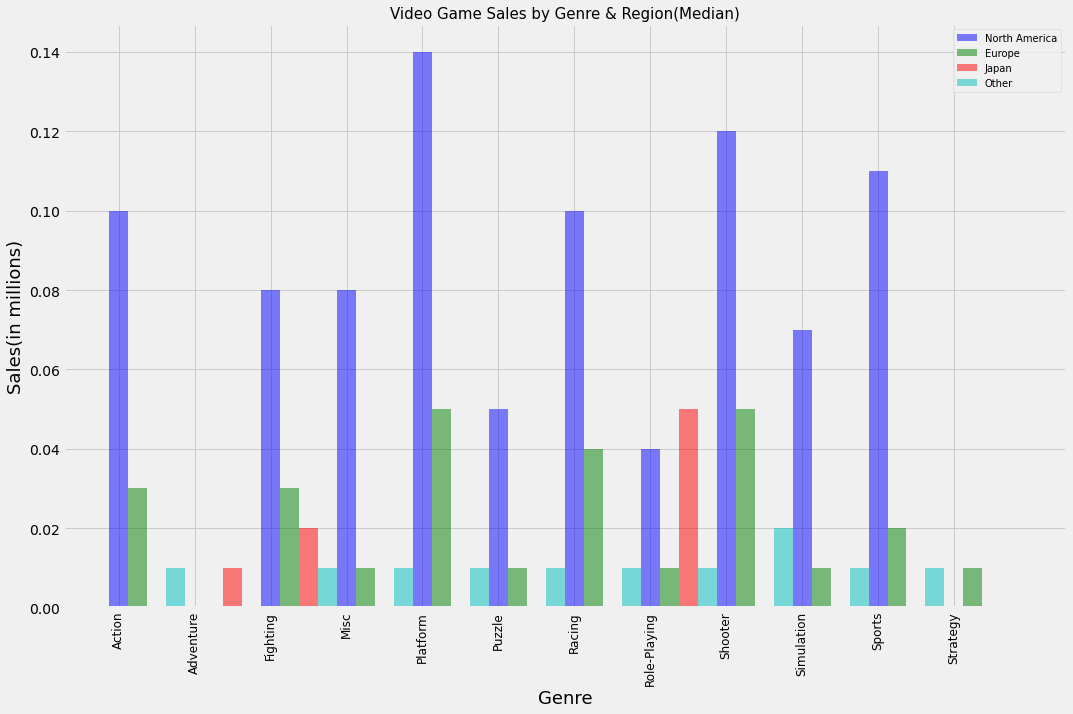

In [9]:
plt.figure(figsize=(16,10))
p5 = plt.bar(index, df_GenReg_1['NA_Sales'], 
             bar_width, 
             color='b', 
             alpha=alpha,
             label='North America')
p6 = plt.bar(index+bar_width, df_GenReg_1['EU_Sales'], 
             bar_width, 
             color='g', 
             alpha=alpha,
             label='Europe')
p7 = plt.bar(index+bar_width*2, df_GenReg_1['JP_Sales'], 
             bar_width, 
             color='r', 
             alpha=alpha,
             label='Japan')
p8 = plt.bar(index+bar_width*3, df_GenReg_1['Other_Sales'], 
             bar_width, 
             color='c', 
             alpha=alpha,
             label='Other')

plt.title('Video Game Sales by Genre & Region(Median)', fontsize=15)
plt.ylabel('Sales(in millions)', fontsize=18)
plt.xlabel('Genre', fontsize=18)
plt.xticks(index, label, fontsize=12, 
           rotation=90)
plt.legend((p5[0], p6[0], p7[0], p8[0]), ('North America', 'Europe', 'Japan', 'Other'), fontsize=10)
plt.show()

두 그래프에서 볼 수 있듯, 지역별로 확연히 선호하는 게임 장르가 다르다. 북미에선 플랫폼 게임, 유럽에서는 슈팅 게임, 일본에서는 롤플레잉 게임, 이외 지역에서는 시뮬레이션 게임이 가장 인기 있는 것으로 보인다.

# **2번: 연도별 게임의 트렌드가 있을까**

게임회사 수는 장르에 비해 매우 많으므로 편의상 가장 많은 게임을 출시한 상위 10개사에 대해서 분석.

In [ ]:
nPub=df['Publisher'].nunique() # 총 게임회사 수=575
pusum=df['Publisher'].value_counts().head(10).sum() # 출시 게임 수 기준 상위 10개 게임회사의 출시 게임 수 총합.
print('상위 10개 게임사 출시 게임의 개수는',pusum ,'개이고,\n이는 결측치를 제외한 총 게임 개수인', len(df),'개의',"{0:.3f}".format(pusum/len(df)), 
      '를 차지한다.\n전체 게임회사의 수에서',"{0:.3f}".format(10/nPub),'정도의 비율을 차지하는 게임회사들이 출시 게임 수에서 약 50%를 포괄한다.'
'\n따라서 이후 게임사 간 연도별 비교를 위해 출시 게임 종류 상위 10개 게임사의 데이터만 이용하기로 한다.'  )

상위 10개 게임사 출시 게임의 개수는 8077 개이고,
이는 결측치를 제외한 총 게임 개수인 16241 개의 0.497 를 차지한다.
전체 게임회사의 수에서 0.017 정도의 비율을 차지하는 게임회사들이 출시 게임 수에서 약 50%를 포괄한다.
따라서 이후 게임사 간 연도별 비교를 위해 출시 게임 종류 상위 10개 게임사의 데이터만 이용하기로 한다.

In [12]:
ct1=pd.crosstab(df['Year'],df['Publisher'])
ct2=pd.crosstab(df['Year'],df['Genre'])
ct3=pd.crosstab(df['Year'],df['Platform'])
ct4=pd.crosstab(df['Publisher'],['Platform'])

In [13]:
Publishers_Name=ct1.sum().sort_values(ascending=False).head(10)
Publishers_Name=Publishers_Name.index
df10=df[df['Publisher'].isin(Publishers_Name)].reset_index(drop=True) # 10개 상위 게임회사의 데이터만 포함한 데이터프레임

상위 10개사 데이터에서 다시 연대별로 나눠서 데이터프레임을 저장.

In [14]:
ydf101=df10[(df10['Year']>= 1980)&(df10['Year']<1990)].reset_index(drop=True) #80년대 출시 게임(상위 10개사)
ydf102=df10[(df10['Year']>= 1990)&(df10['Year']<2000)].reset_index(drop=True) #90년대 출시 게임(상위 10개사)
ydf103=df10[(df10['Year']>= 2000)&(df10['Year']<2010)].reset_index(drop=True) #2000년대 출시 게임(상위 10개사)
ydf104=df10[(df10['Year']>= 2010)].reset_index(drop=True) #2010년대(상위 10개사)

연대별로 게임을 출시한 회사들의 출시한 게임 종류 수.

In [15]:
pub_counts_80=ydf101['Publisher'].value_counts()
pub_counts_90=ydf102['Publisher'].value_counts()
pub_counts_00=ydf103['Publisher'].value_counts()
pub_counts_10=ydf104['Publisher'].value_counts()
df_pub_decade=pd.concat([pub_counts_80,pub_counts_90,pub_counts_00,pub_counts_10],axis=1).fillna(0).astype(int) # 연대별 10개사의 게임 출시 빈도
df_pub_decade.columns=['80s','90s','2000s','2010s'] 
df_pub_decade=df_pub_decade.T

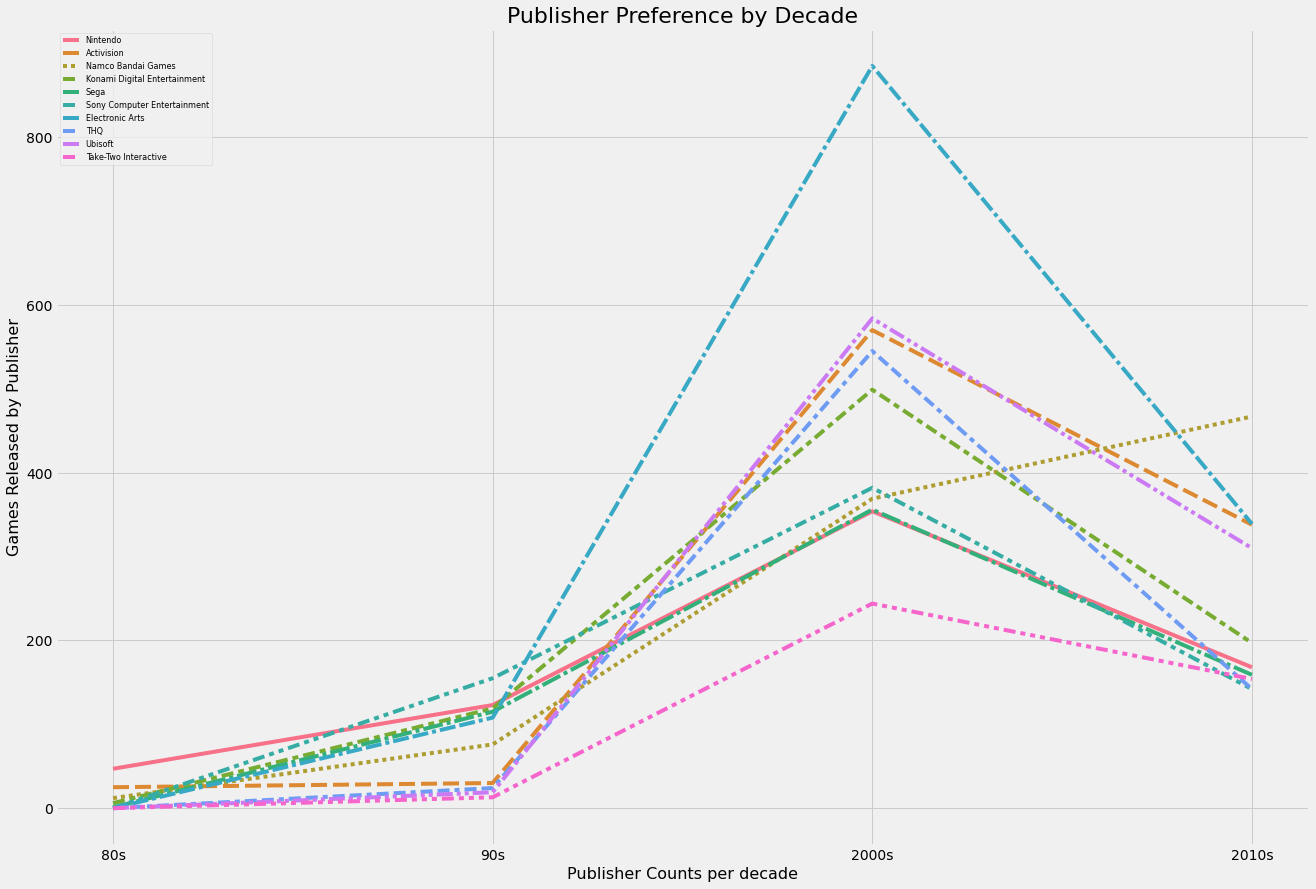

In [16]:
plt.figure(figsize=(20,14))
ax = sns.lineplot(data=df_pub_decade)

plt.title('Publisher Preference by Decade', fontsize=22)
plt.ylabel('Games Released by Publisher', fontsize=16)
plt.xlabel('Publisher Counts per decade', fontsize=16)
plt.legend(fontsize=8, loc='upper left')

plt.show()

장르를 기준으로 교차표를 작성할 때에는, 게임회사 경우와는 다르게 장르 수가 많지 않으므로 전체 게임을 대상으로 했고, 연도별로 게임 장르별 출시 게임수가 얼마나 되는지로 게임에 대한 트렌드가 있는지 확인했다.

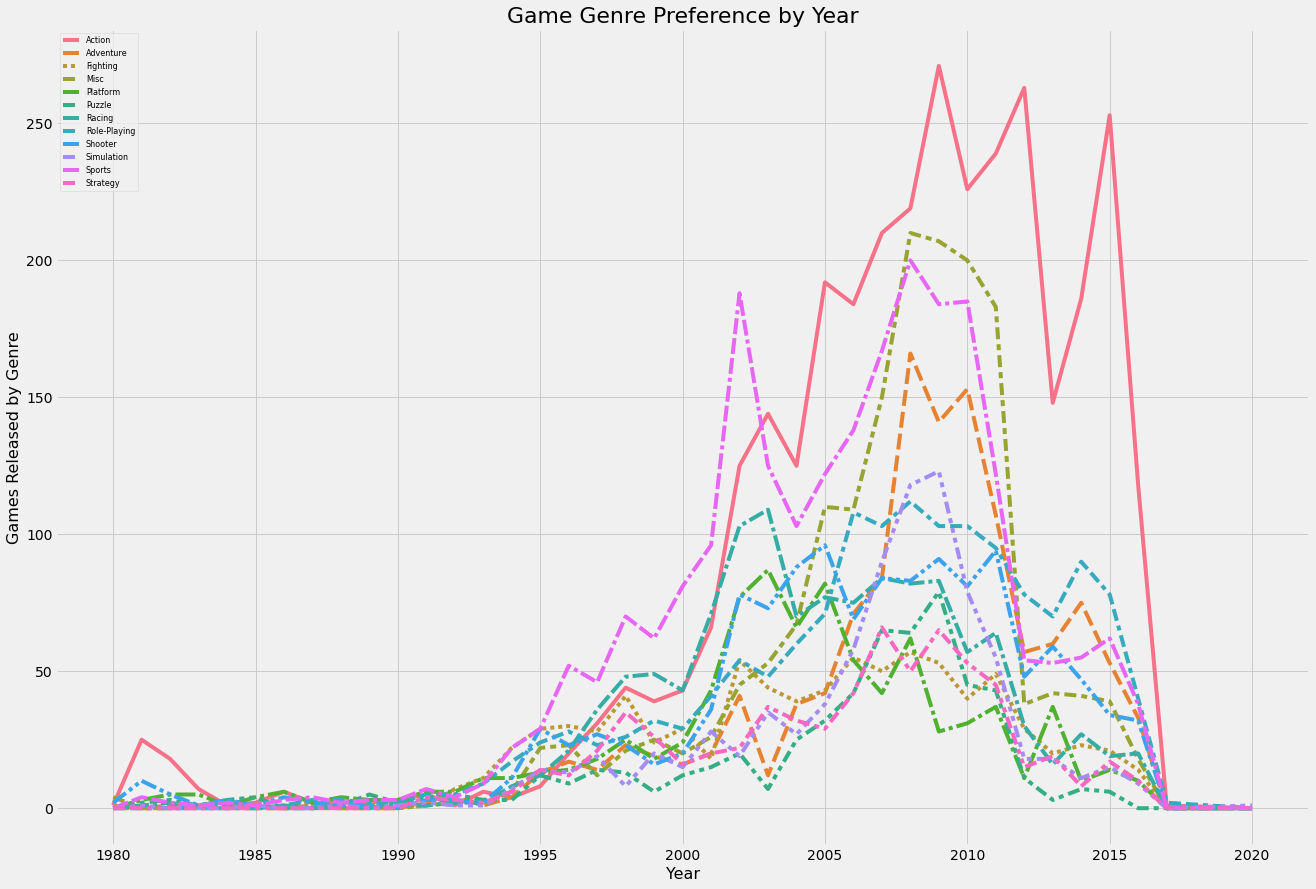

In [17]:
plt.figure(figsize=(20,14))
ax = sns.lineplot(data=ct2)

plt.title('Game Genre Preference by Year', fontsize=22)
plt.ylabel('Games Released by Genre', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.legend(fontsize=8, loc='upper left')

plt.show()

10년 단위로 장르 출시 빈도에 대한 분석을 실시했다.

In [18]:
genre_counts_80=ydf1['Genre'].value_counts()
genre_counts_90=ydf2['Genre'].value_counts()
genre_counts_00=ydf3['Genre'].value_counts()
genre_counts_10=ydf4['Genre'].value_counts()
df_genre_decade=pd.concat([genre_counts_80,genre_counts_90,genre_counts_00,genre_counts_10],axis=1).fillna(0).astype(int) # 연대별 게임 장르 출시 빈도(전체 게임)
df_genre_decade.columns=['80s','90s','2000s','2010s'] 
df_genre_decade=df_genre_decade.T

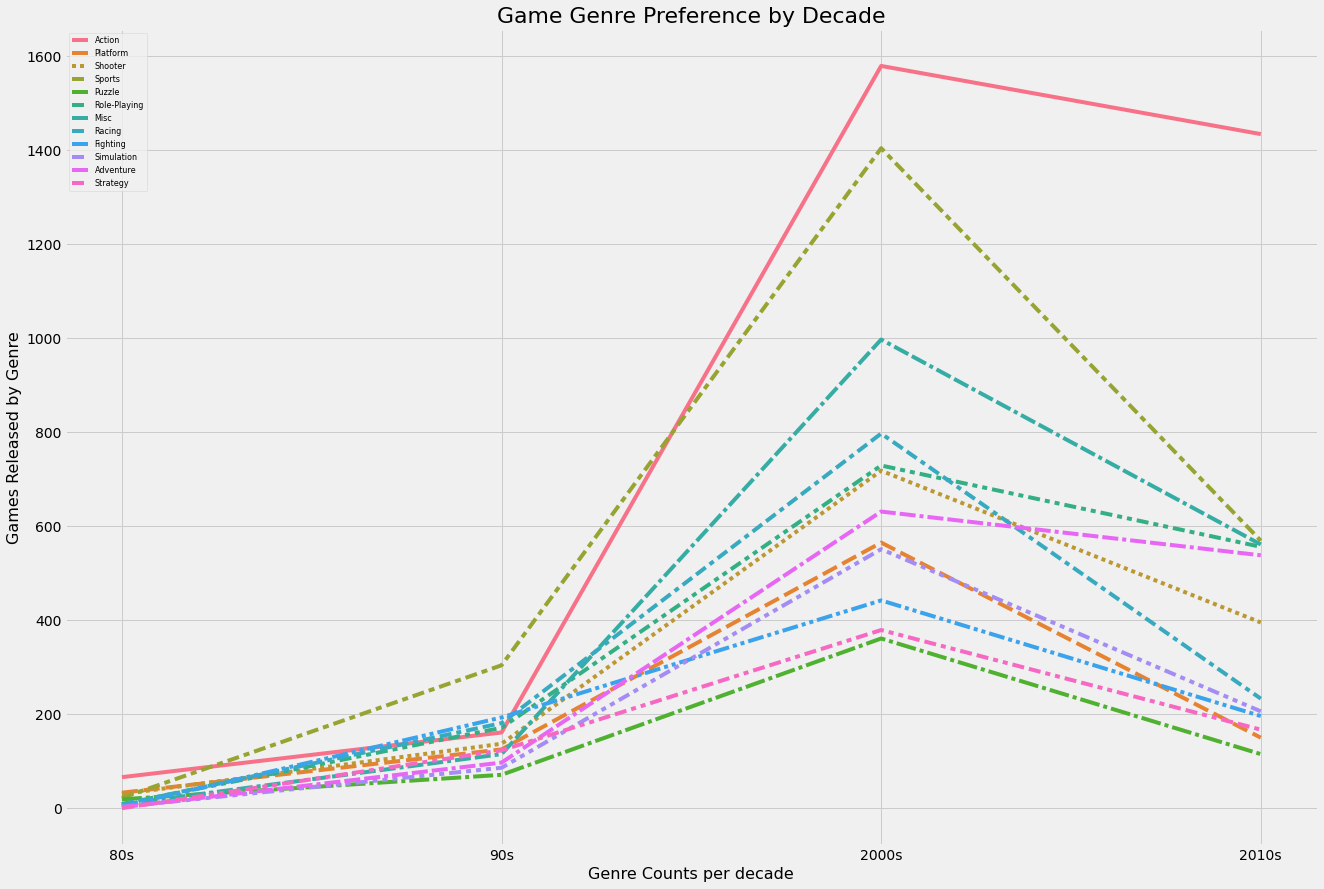

In [19]:
plt.figure(figsize=(20,14))
ax = sns.lineplot(data=df_genre_decade)

plt.title('Game Genre Preference by Decade', fontsize=22)
plt.ylabel('Games Released by Genre', fontsize=16)
plt.xlabel('Genre Counts per decade', fontsize=16)
plt.legend(fontsize=8, loc='upper left')

plt.show()

10년 단위로 장르별 전세계 총 출고량을 비교해 봤다.

In [20]:
sales_80=ydf1.groupby(by='Genre').mean()['Global_Sales']
sales_90=ydf2.groupby(by='Genre').mean()['Global_Sales']
sales_00=ydf3.groupby(by='Genre').mean()['Global_Sales']
sales_10=ydf4.groupby(by='Genre').mean()['Global_Sales']
df_sales_decade=pd.concat([sales_80,sales_90,sales_00,sales_10],axis=1).fillna(0) # 10년 단위 장르별 평균 총 출고량
df_sales_decade.columns=['Sales in 80s','Sales in 90s','Sales in 2000s','Sales in 2010s']
df_sales_decade=df_sales_decade.T

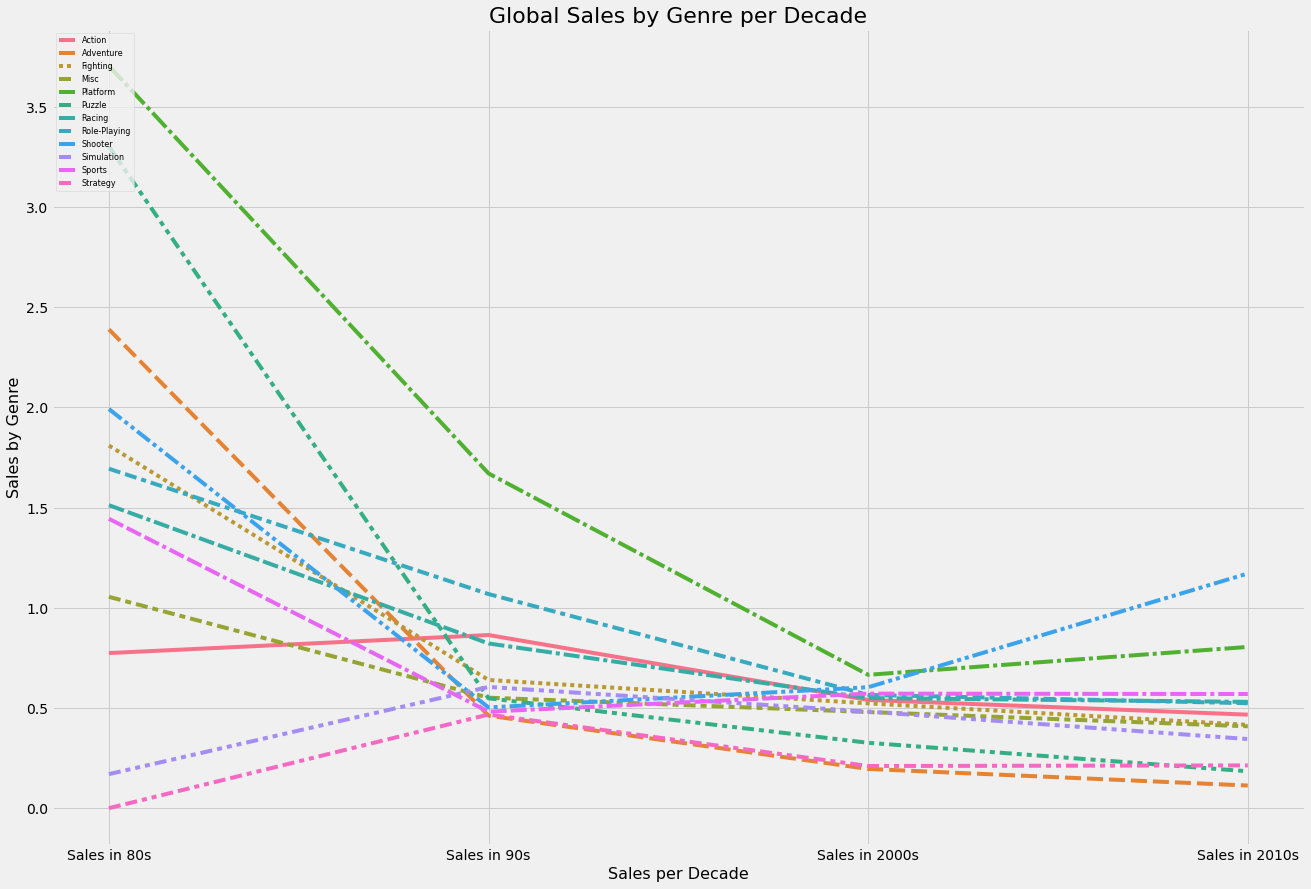

In [21]:
plt.figure(figsize=(20,14))
ax = sns.lineplot(data=df_sales_decade)

plt.title('Global Sales by Genre per Decade', fontsize=22)
plt.ylabel('Sales by Genre', fontsize=16)
plt.xlabel('Sales per Decade', fontsize=16)
plt.legend(fontsize=8, loc='upper left')

plt.show()

연도별 지역 및 전세계 출고량 변화.

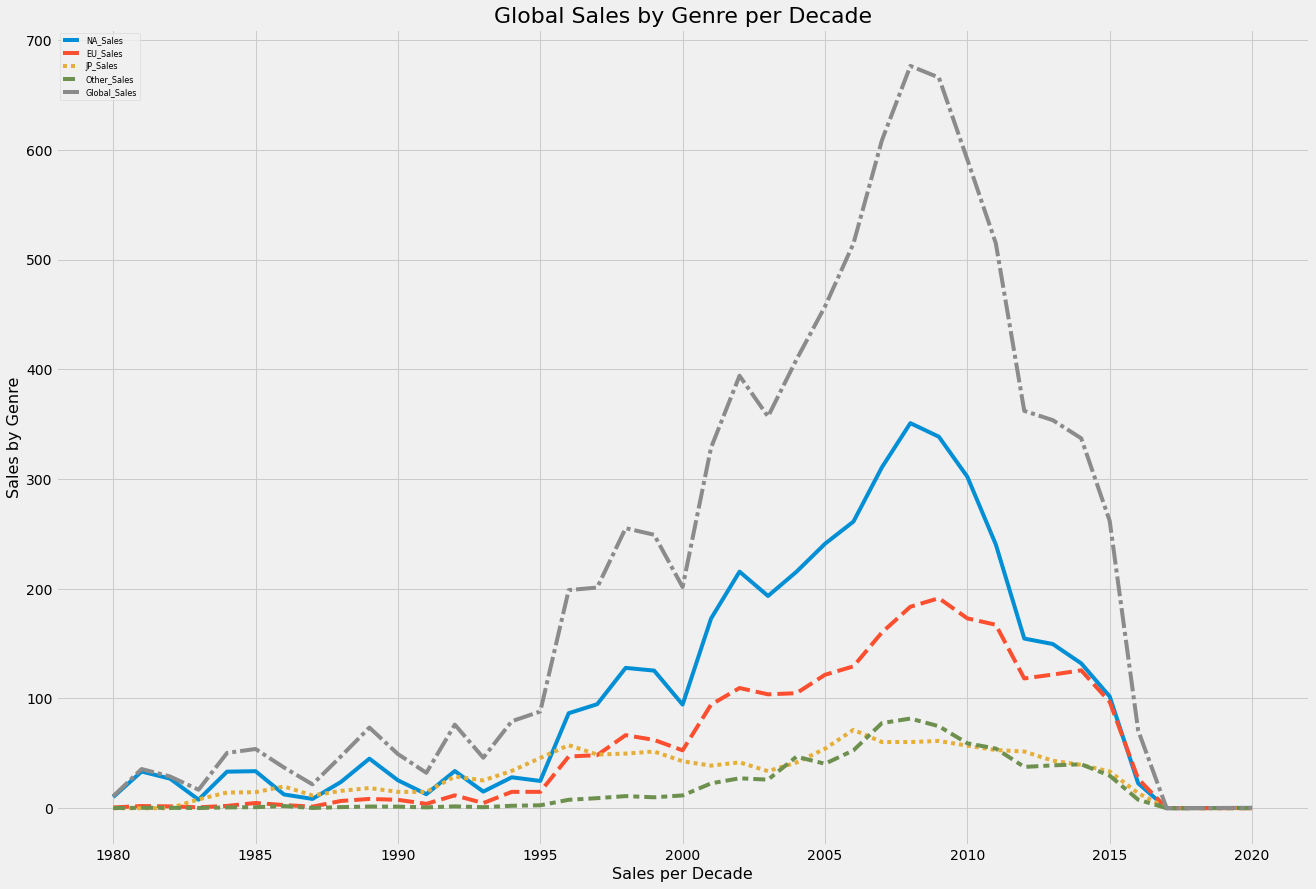

In [22]:
df_sales_sum_year=df.groupby('Year').sum() # 연도별 트렌드를 설명하면서 덧붙여서 연도별 출고량의 변화도 보여주고(시각화), 그리고 거기에 내 해석을 붙일 것.
plt.figure(figsize=(20,14))
ax = sns.lineplot(data=df_sales_sum_year)

plt.title('Global Sales by Genre per Decade', fontsize=22)
plt.ylabel('Sales by Genre', fontsize=16)
plt.xlabel('Sales per Decade', fontsize=16)
plt.legend(fontsize=8, loc='upper left')

plt.show()

# **3. 출고량이 높은 게임에 대한 분석 및 시각화**
### 여기서는 전세계 출고량 순으로 상위 100개사에 대해서 분석을 진행했다.

In [23]:
sales_all=df.Global_Sales.sum() # 데이터 상 모든 게임 전세계 출고량 합
sales_100=df.sort_values(by='Global_Sales',ascending=False).head(100).Global_Sales.sum() # 전세계 출고량 상위 100개 게임 출고량 합
rat_100=sales_100/sales_all # 상위 100개 게임의 출고량 대 전체 출고량 비율 = 0.166

In [24]:
rat_NA=df.NA_Sales.sum()/sales_all # 전세계 총 출고량에 대한 북미 총 출고량의 비율 = 0.492
rat_EU=df.EU_Sales.sum()/sales_all # 전세계 총 출고량에 대한 유럽 총 출고량의 비율 = 0.273
rat_JP=df.JP_Sales.sum()/sales_all # 전세계 총 출고량에 대한 일본 총 출고량의 비율 = 0.145

In [25]:
df_g100=df.sort_values(by='Global_Sales',ascending=False).head(100).reset_index(drop=True)
df_g100

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.38
...,...,...,...,...,...,...,...,...,...,...
95,Super Smash Bros. for Wii U and 3DS,3DS,2014,Fighting,Nintendo,3.24,1.35,2.42,0.43,7.44
96,Call of Duty: World at War,X360,2008,Shooter,Activision,4.79,1.90,0.00,0.69,7.38
97,Battlefield 3,X360,2011,Shooter,Electronic Arts,4.46,2.13,0.06,0.69,7.34
98,The Legend of Zelda: Twilight Princess,Wii,2006,Action,Nintendo,3.83,2.19,0.60,0.70,7.32


In [27]:
pop_plat_100=df_g100['Platform'].value_counts().head(5) # 상위 100개 게임에서 가장 인기 있는 플랫폼 5개.
pop_pub_100=df_g100['Publisher'].value_counts().head(5) # 상위 100개 게임에서 가장 인기 있는 게임회사 5개. 
pop_gen_100=df_g100['Genre'].value_counts().head(5) # 상위 100개 게임에서 가장 인기 있는 게임 장르 5개.
pop_plat_100

X360    16
Wii     15
DS      13
PS3      9
GB       6
Name: Platform, dtype: int64

In [28]:
pop_pub_100

Nintendo                       51
Activision                     15
Take-Two Interactive            9
Sony Computer Entertainment     8
Microsoft Game Studios          6
Name: Publisher, dtype: int64

In [29]:
pop_gen_100

Shooter         23
Platform        16
Role-Playing    14
Action          13
Racing          10
Name: Genre, dtype: int64

상위 100개 게임을 연도를 가로축으로 하는 산점도 위에 장르 기준으로 다른 색상과 형태로 표시.

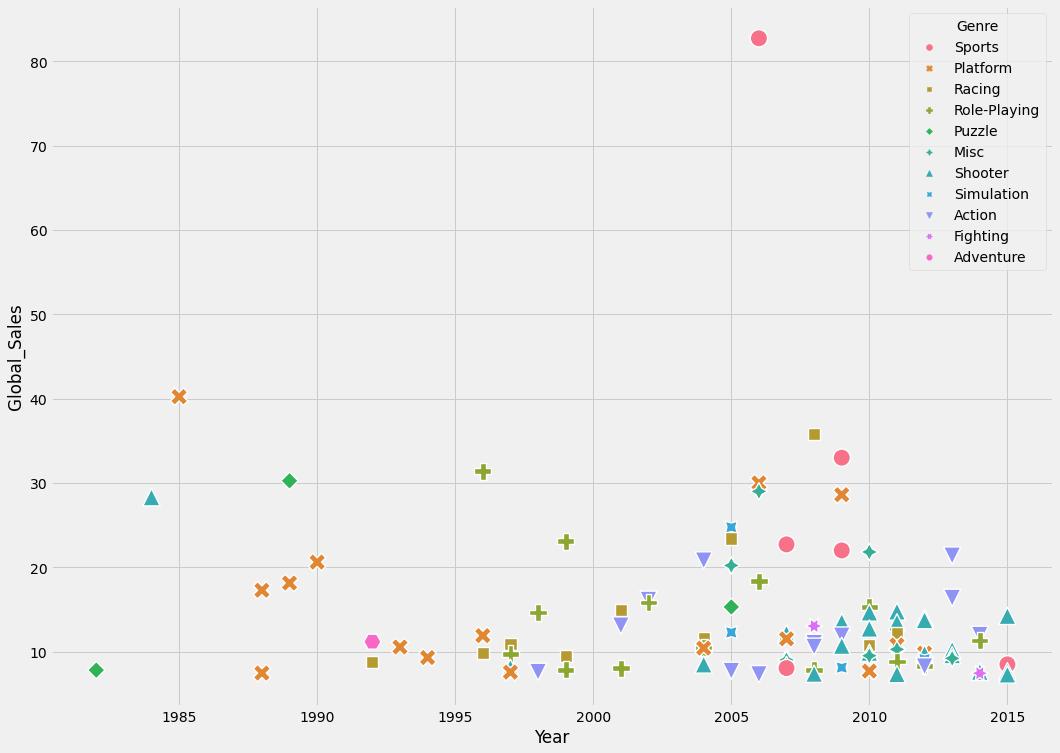

In [30]:
plt.figure(figsize=(16,12))
sns.scatterplot(x='Year', 
                y='Global_Sales', 
                hue='Genre', # 장르를 기준으로 다른 색
                style='Genre', # 장르를 기준으로 다른 모양
                s=300,
                data=df_g100)

plt.show()

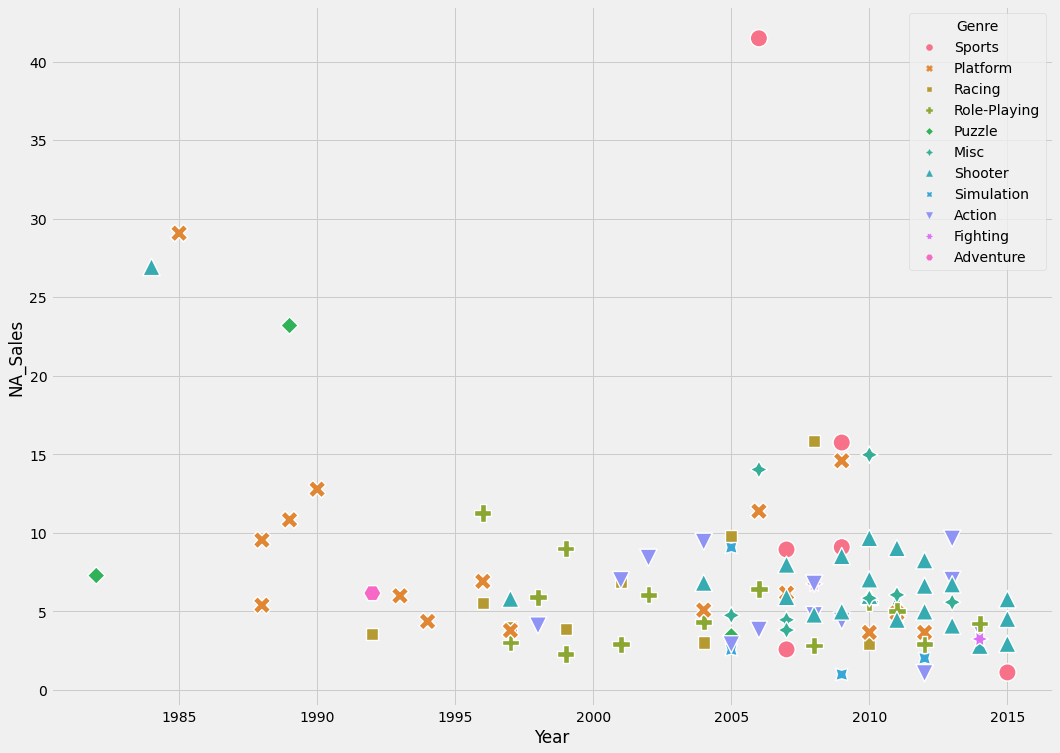

In [31]:
plt.figure(figsize=(16,12))
sns.scatterplot(x='Year', 
                y='NA_Sales', 
                hue='Genre', # 장르를 기준으로 다른 색
                style='Genre', # 장르를 기준으로 다른 모양
                s=300,
                data=df_g100)

plt.show()

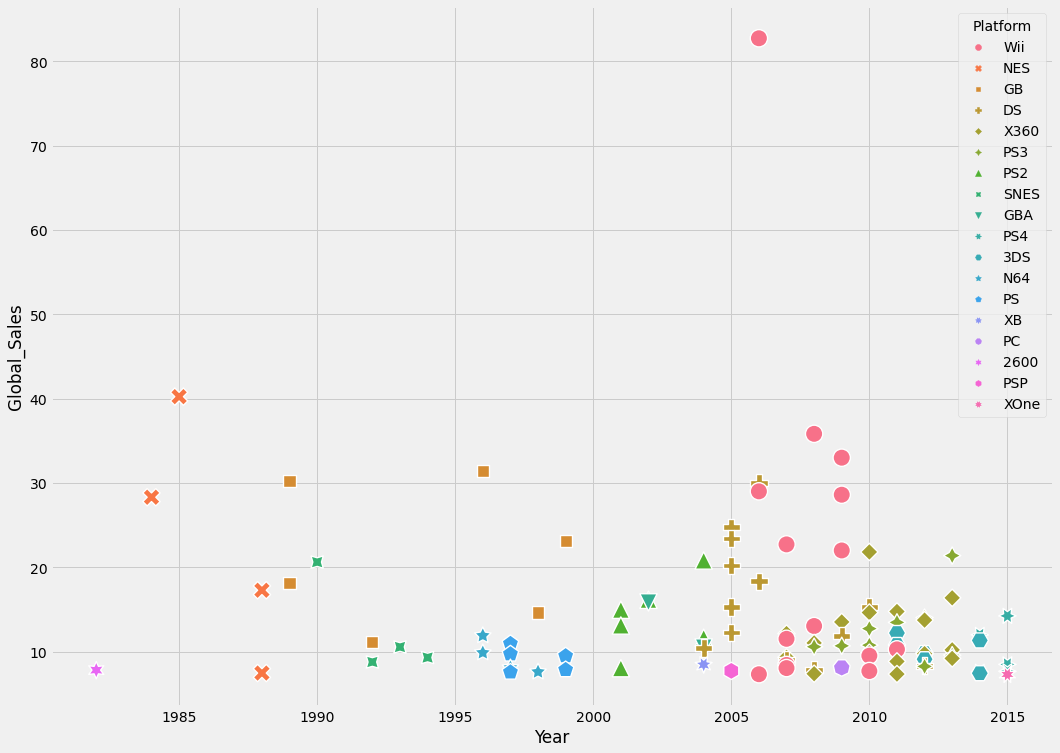

In [32]:
plt.figure(figsize=(16,12))
sns.scatterplot(x='Year', 
                y='Global_Sales', 
                hue='Platform', # 장르를 기준으로 다른 색
                style='Platform', # 장르를 기준으로 다른 모양
                s=300,
                data=df_g100)

plt.show()

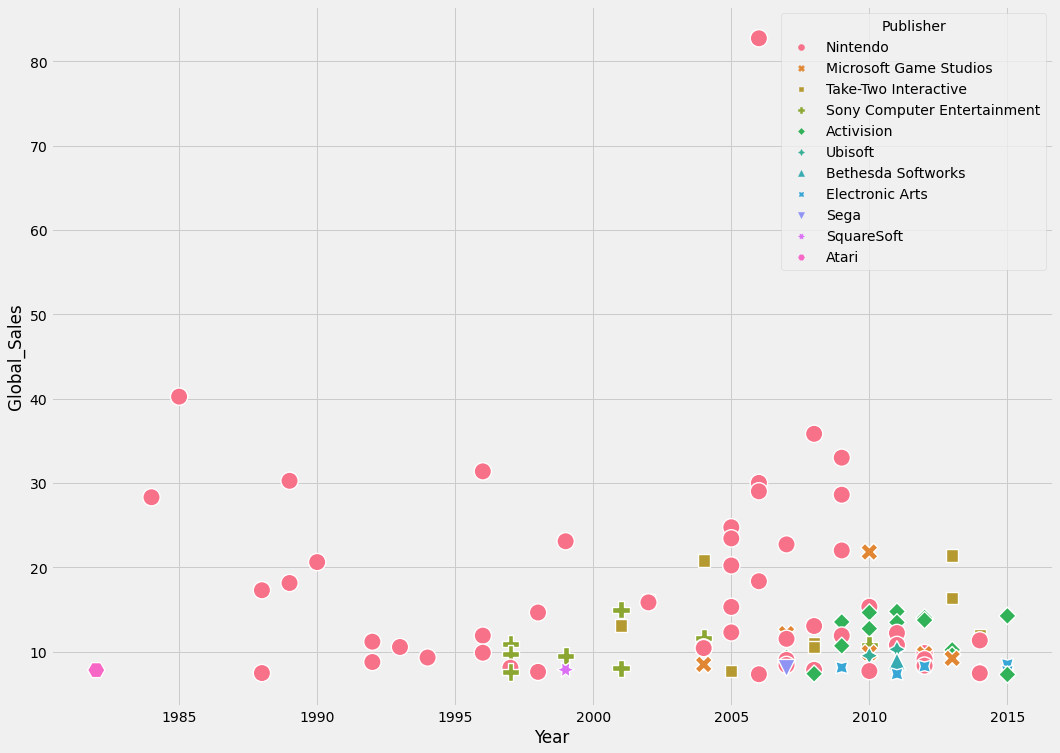

In [33]:
plt.figure(figsize=(16,12))
sns.scatterplot(x='Year', 
                y='Global_Sales', 
                hue='Publisher', # 출시 플랫폼을 기준으로 다른 색
                style='Publisher', # 출시 플랫폼 기준으로 다른 모양
                s=300,
                data=df_g100)

plt.show()

상위 100개 게임에 대한 가설 검정.

In [34]:
ct11=pd.crosstab(df_g100['Publisher'],df_g100['Genre']) # 귀무가설: (출고량 상위 100개 게임 중) 출시 회사와 장르는 서로 독립적이다.
stats.chi2_contingency(observed=ct11) # 해석: p값이 1.42e-16정도로 매우 작으므로, 귀무가설을 기각한다. 따라서 출시 회사와 장르는 종속적이다. 이는 잘 되는 게임을 하나 출시한 회사가 그와 같은 장르의 게임을 출시함으로써 지속적으로 수익을 내려고 하는 것이라 해석할 수 있다.

(262.8525333628435,
 1.4230728699359674e-16,
 100,
 array([[1.950e+00, 1.500e-01, 3.000e-01, 1.200e+00, 2.400e+00, 4.500e-01,
         1.500e+00, 2.100e+00, 3.450e+00, 6.000e-01, 9.000e-01],
        [1.300e-01, 1.000e-02, 2.000e-02, 8.000e-02, 1.600e-01, 3.000e-02,
         1.000e-01, 1.400e-01, 2.300e-01, 4.000e-02, 6.000e-02],
        [1.300e-01, 1.000e-02, 2.000e-02, 8.000e-02, 1.600e-01, 3.000e-02,
         1.000e-01, 1.400e-01, 2.300e-01, 4.000e-02, 6.000e-02],
        [6.500e-01, 5.000e-02, 1.000e-01, 4.000e-01, 8.000e-01, 1.500e-01,
         5.000e-01, 7.000e-01, 1.150e+00, 2.000e-01, 3.000e-01],
        [7.800e-01, 6.000e-02, 1.200e-01, 4.800e-01, 9.600e-01, 1.800e-01,
         6.000e-01, 8.400e-01, 1.380e+00, 2.400e-01, 3.600e-01],
        [6.630e+00, 5.100e-01, 1.020e+00, 4.080e+00, 8.160e+00, 1.530e+00,
         5.100e+00, 7.140e+00, 1.173e+01, 2.040e+00, 3.060e+00],
        [1.300e-01, 1.000e-02, 2.000e-02, 8.000e-02, 1.600e-01, 3.000e-02,
         1.000e-01, 1.400e-01, 2.3

In [35]:
ct12=pd.crosstab(df_g100['Publisher'],df_g100['Platform']) # 귀무가설: (출고량 상위 100개 게임 중) 출시 회사와 이용하는 게임의 플랫폼은 서로 독립적이다.
stats.chi2_contingency(observed=ct12) # 해석: p값이 3.43e-17 정도로 유의 수준 0.05보다 매우 작게 나왔으므로 귀무가설을 기각한다. 따라서 출시 회사와 게임 플랫폼은 종속적이다. 
#이와 같은 결과에서, 한 가지 성공하는 게임을 이미 개발했다면 그와 같은 플랫폼을 이용하는 것이 나을 것이라고 해석할 수 있다.

(372.5147966594045,
 3.432826877588761e-17,
 170,
 array([[0.15, 0.9 , 1.95, 0.9 , 0.3 , 0.6 , 0.6 , 0.15, 0.75, 0.9 , 1.35,
         0.75, 0.15, 0.6 , 2.25, 2.4 , 0.15, 0.15],
        [0.01, 0.06, 0.13, 0.06, 0.02, 0.04, 0.04, 0.01, 0.05, 0.06, 0.09,
         0.05, 0.01, 0.04, 0.15, 0.16, 0.01, 0.01],
        [0.01, 0.06, 0.13, 0.06, 0.02, 0.04, 0.04, 0.01, 0.05, 0.06, 0.09,
         0.05, 0.01, 0.04, 0.15, 0.16, 0.01, 0.01],
        [0.05, 0.3 , 0.65, 0.3 , 0.1 , 0.2 , 0.2 , 0.05, 0.25, 0.3 , 0.45,
         0.25, 0.05, 0.2 , 0.75, 0.8 , 0.05, 0.05],
        [0.06, 0.36, 0.78, 0.36, 0.12, 0.24, 0.24, 0.06, 0.3 , 0.36, 0.54,
         0.3 , 0.06, 0.24, 0.9 , 0.96, 0.06, 0.06],
        [0.51, 3.06, 6.63, 3.06, 1.02, 2.04, 2.04, 0.51, 2.55, 3.06, 4.59,
         2.55, 0.51, 2.04, 7.65, 8.16, 0.51, 0.51],
        [0.01, 0.06, 0.13, 0.06, 0.02, 0.04, 0.04, 0.01, 0.05, 0.06, 0.09,
         0.05, 0.01, 0.04, 0.15, 0.16, 0.01, 0.01],
        [0.08, 0.48, 1.04, 0.48, 0.16, 0.32, 0.32, 0.08, 0.4 

In [36]:
ct13=pd.crosstab(df_g100['Platform'],df_g100['Genre']) # 귀무가설: (출고량 상위 100개 게임 중) 출시 플랫폼과 장르는 서로 독립적이다.
stats.chi2_contingency(observed=ct13) # p값이 5.95e-6 정도로 유의 수준 0.05보다 매우 작으므로 귀무가설을 기각한다. 따라서 출시 플랫폼과 장르는 일반적으로 종속적이다. 

(263.1586354698813,
 5.951488548530756e-06,
 170,
 array([[0.13, 0.01, 0.02, 0.08, 0.16, 0.03, 0.1 , 0.14, 0.23, 0.04, 0.06],
        [0.78, 0.06, 0.12, 0.48, 0.96, 0.18, 0.6 , 0.84, 1.38, 0.24, 0.36],
        [1.69, 0.13, 0.26, 1.04, 2.08, 0.39, 1.3 , 1.82, 2.99, 0.52, 0.78],
        [0.78, 0.06, 0.12, 0.48, 0.96, 0.18, 0.6 , 0.84, 1.38, 0.24, 0.36],
        [0.26, 0.02, 0.04, 0.16, 0.32, 0.06, 0.2 , 0.28, 0.46, 0.08, 0.12],
        [0.52, 0.04, 0.08, 0.32, 0.64, 0.12, 0.4 , 0.56, 0.92, 0.16, 0.24],
        [0.52, 0.04, 0.08, 0.32, 0.64, 0.12, 0.4 , 0.56, 0.92, 0.16, 0.24],
        [0.13, 0.01, 0.02, 0.08, 0.16, 0.03, 0.1 , 0.14, 0.23, 0.04, 0.06],
        [0.65, 0.05, 0.1 , 0.4 , 0.8 , 0.15, 0.5 , 0.7 , 1.15, 0.2 , 0.3 ],
        [0.78, 0.06, 0.12, 0.48, 0.96, 0.18, 0.6 , 0.84, 1.38, 0.24, 0.36],
        [1.17, 0.09, 0.18, 0.72, 1.44, 0.27, 0.9 , 1.26, 2.07, 0.36, 0.54],
        [0.65, 0.05, 0.1 , 0.4 , 0.8 , 0.15, 0.5 , 0.7 , 1.15, 0.2 , 0.3 ],
        [0.13, 0.01, 0.02, 0.08, 0.16,

In [37]:
def isShooter(x): # 슈팅 게임이면 1, 아니면 0을 출력
  if x=='Shooter':
    return 1
  else:
    return 0

def NAratio(x): #  해당 게임의 (북미 출고량)/(전세계 출고량) 비율이 (북미 총 출고량)/(전세계 총 출고량) 비율보다 크면 1을 출력, 아니면 0을 출력하는 함수. 다른지역에서보다 북미에서 잘 팔리는지 확인하는 것.
  if x>=rat_NA:
    return 1
  else:
    return 0

def isRP(x): # 롤플레잉 게임이면 1, 아니면 0을 출력
  if x=='Role-Playing':
    return 1
  else:
    return 0

def JPratio(x): # 해당 게임의 (일본 출고량)/(전세계 출고량) 비율이 (일본 총 출고량)/(전세계 총 출고량) 비율보다 크면 1을 출력, 아니면 0을 출력하는 함수. 다른지역에서보다 일본에서 잘 팔리는지 확인하는 것.
  if x>=rat_JP:
    return 1
  else:
    return 0

In [38]:
df_temp=df_g100.copy() # 임시 계산용
df_temp['NA_r']=df_g100['NA_Sales']/df_g100['Global_Sales'] # 북미 출고량과 전세계 출고량 비율을 'NA_r'에 저장
df_temp['NA_ratio']=df_temp['NA_r'].apply(NAratio)
df_temp['shooter']=df_g100['Genre'].apply(isShooter)
df_temp['JP_r']=df_g100['JP_Sales']/df_g100['Global_Sales'] # 일본 출고량과 전세계 출고량 비율을 'NA_r'에 저장
df_temp['JP_ratio']=df_temp['JP_r'].apply(JPratio)
df_temp['rp']=df_g100['Genre'].apply(isRP)
df_temp

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,NA_r,NA_ratio,shooter,JP_r,JP_ratio,rp
0,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,0.501450,1,0,0.045564,0,0
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,0.722664,1,0,0.169235,1,0
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83,0.442367,0,0,0.105777,0,0
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,0.477273,0,0,0.099394,0,0
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.38,0.359146,0,0,0.325685,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Super Smash Bros. for Wii U and 3DS,3DS,2014,Fighting,Nintendo,3.24,1.35,2.42,0.43,7.44,0.435484,0,0,0.325269,1,0
96,Call of Duty: World at War,X360,2008,Shooter,Activision,4.79,1.90,0.00,0.69,7.38,0.649051,1,1,0.000000,0,0
97,Battlefield 3,X360,2011,Shooter,Electronic Arts,4.46,2.13,0.06,0.69,7.34,0.607629,1,1,0.008174,0,0
98,The Legend of Zelda: Twilight Princess,Wii,2006,Action,Nintendo,3.83,2.19,0.60,0.70,7.32,0.523224,1,0,0.081967,0,0


In [39]:
ct14=pd.crosstab(df_temp['shooter'],df_temp['NA_ratio']) # 귀무가설: (출고량 상위 100개 게임 중) 게임이 슈팅 게임인지 여부와 북미 출고량이 총 출고량에서 (북미 총 출고량/전세계 총 출고량) 이상 차지하는지 여부는 독립적이다.
stats.chi2_contingency(observed=ct14) # 해석: p값은 0.0269 정도로 유의 수준 0.05보다 작다. 따라서 귀무가설을 기각한다. 두 가지는 독립적이지 않고 종속적이다. 

(4.895983869960773, 0.026919230553931653, 1, array([[43.89, 33.11],
        [13.11,  9.89]]))

In [40]:
ct15=pd.crosstab(df_temp['rp'],df_temp['JP_ratio']) # 귀무가설: (출고량 상위 100개 게임 중) 게임이 롤플레잉 게임인지 여부와 일본 출고량이 총 출고량에서 (일본 총 출고량/전세계 총 출고량) 이상 차지하는지 여부는 독립적이다. 
stats.chi2_contingency(observed=ct15) # 해석: p값은 1.618e-4 정도로 유의 수준 0.05보다 많이 작다. 따라서 귀무가설을 기각한다. 두 가지는 독립적이지 않고 종속적이다. 
# 이는 롤플레잉 게임 여부와 일본 출고량의 전체 출고량 비율 간 종속성이 슈팅 게임과 북미 출고량의 전체 출고량 비율 사이 종속성보다 크다는 의미.

(14.229191149859506, 0.00016184040964421995, 1, array([[49.02, 36.98],
        [ 7.98,  6.02]]))

#**4. 추가 분석**

각 지역 간 출고량과 전체 출고량의 상관관계


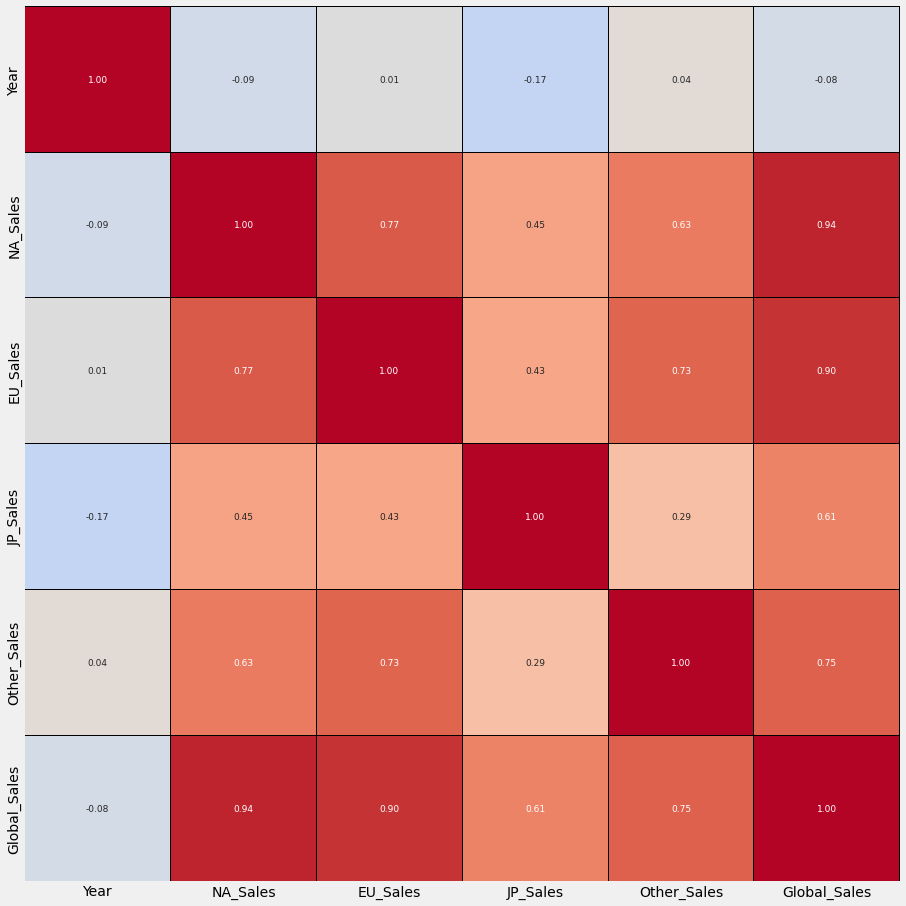

In [41]:
def heatmap(df):
    
    fig, ax = plt.subplots(figsize = (15, 15))
    
    sns.heatmap(df.corr(), cmap = "coolwarm", annot = True, fmt = ".2f", annot_kws = {"fontsize": 9},
                vmin = -1, vmax = 1, square = True, linewidths = 0.01, linecolor = "black", cbar = False)
    
    sns.despine(top = True, right = True, left = True, bottom = True)

heatmap(df) 
# 지역별 출고량과 전체 출고량의 상관관계

연대에 따라서 지역별 출고량이 총 출고량에 얼마나 영향을 끼쳤는지

(None, None, None, None)

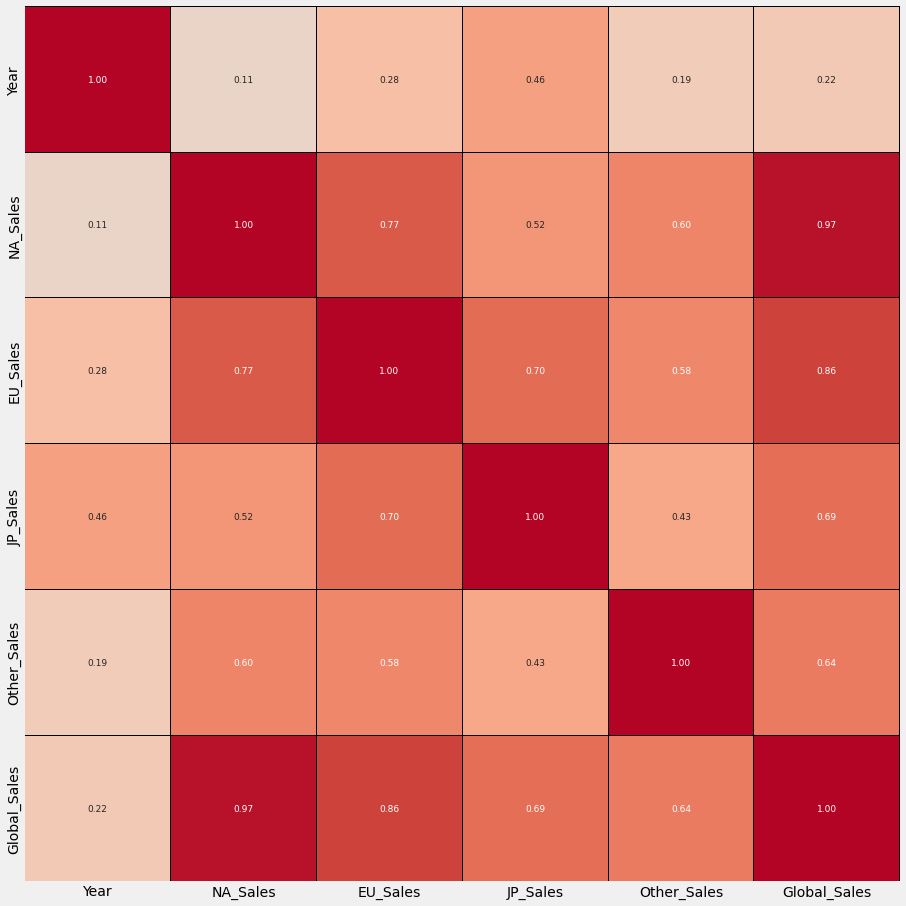

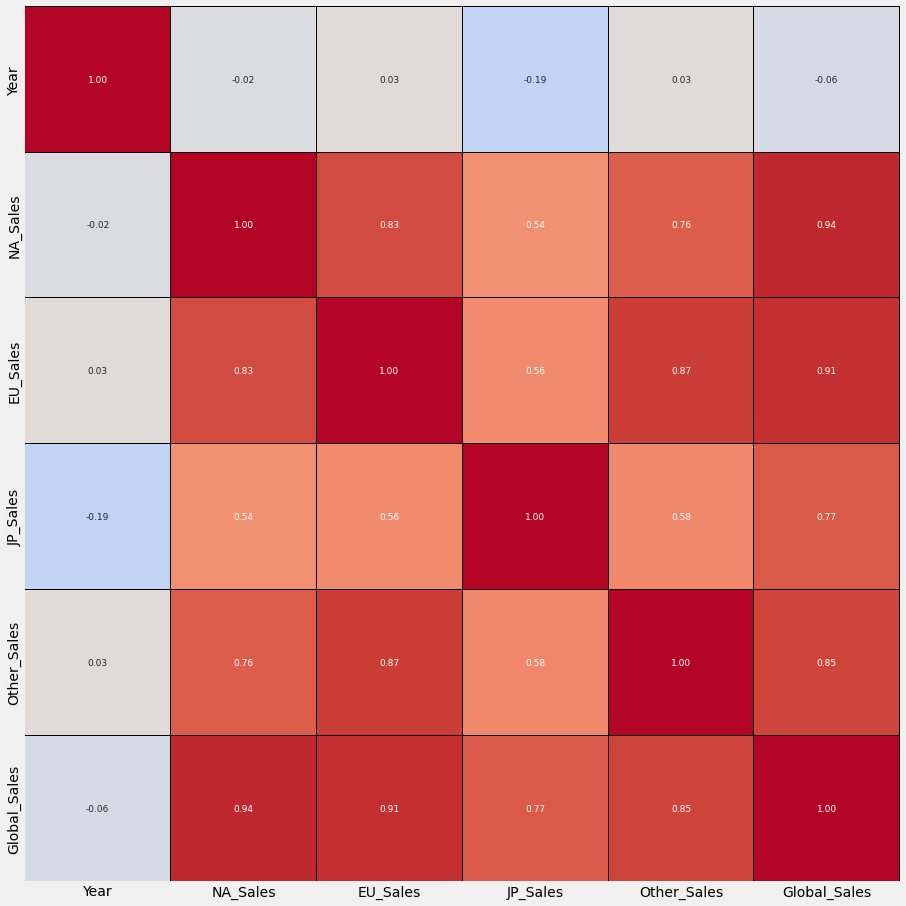

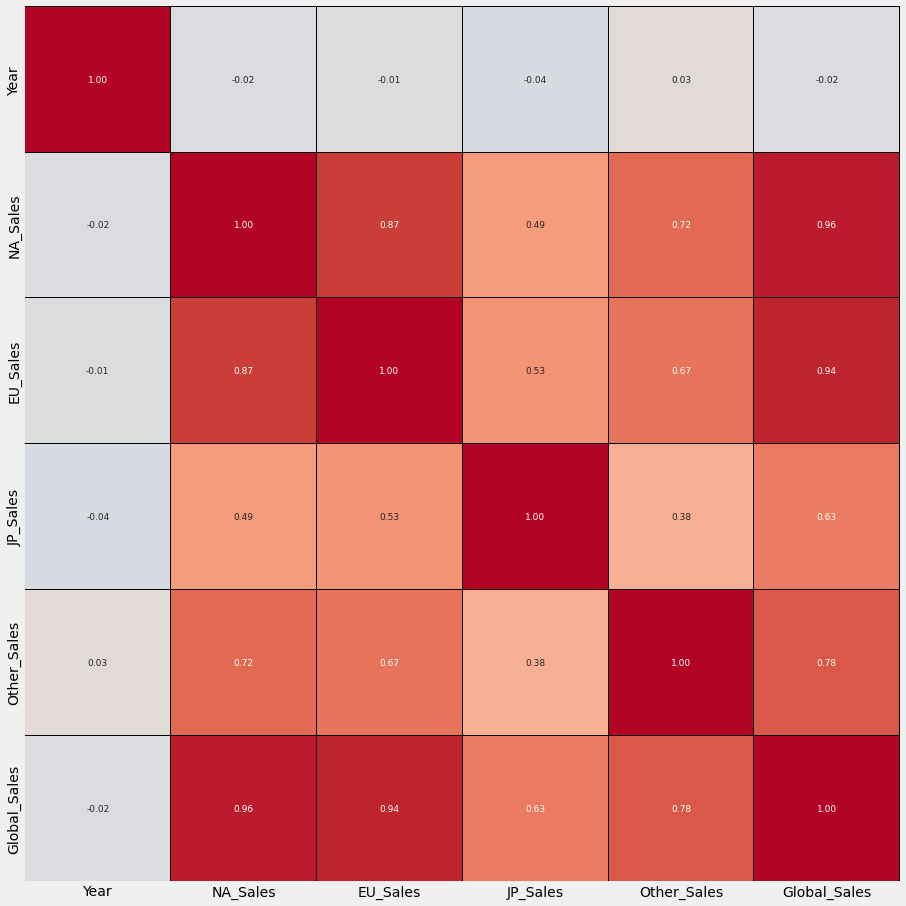

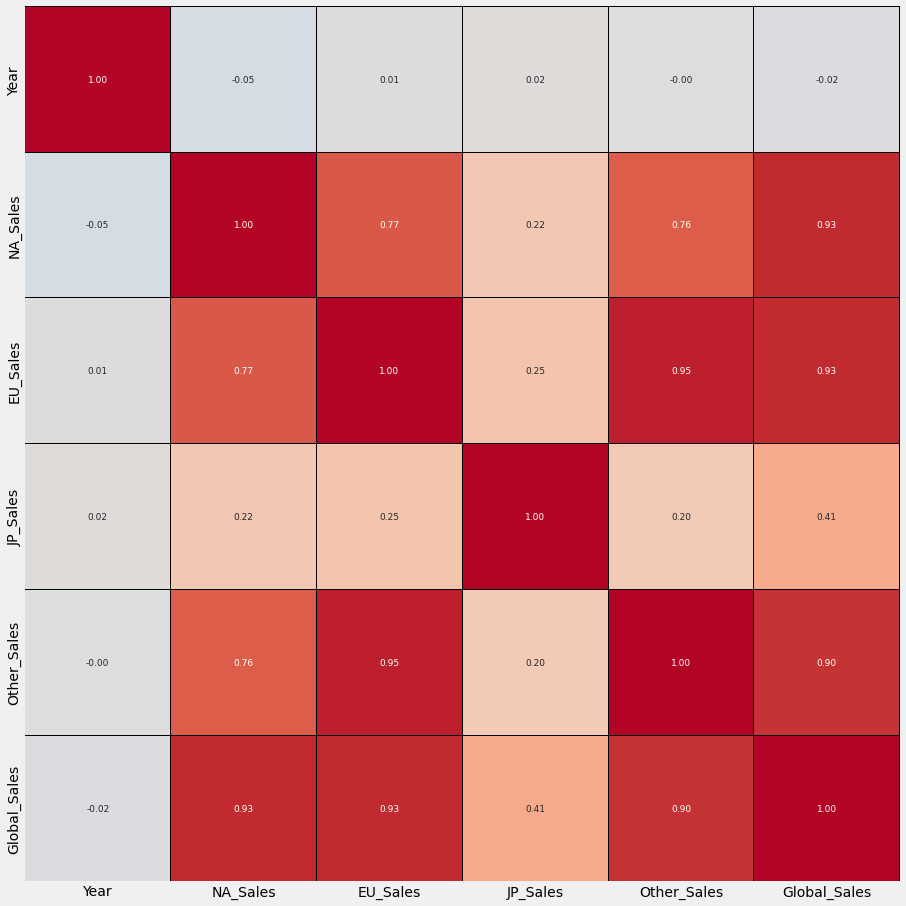

In [42]:
heatmap(ydf1), heatmap(ydf2), heatmap(ydf3), heatmap(ydf4) # 연대에 따라서 지역별 출고량이 총 출고량에 얼마나 영향 끼쳤는지 보여주기

# **5. 결론**

1. 지역에 따라 선호하는 게임 장르는 다르다. 전세계 출고량과 가장 큰 상관계수를 가지는 북미 지역을 예로 들면 플랫폼 게임이 가장 인기 있으며, 이 점을 염두하고 게임을 개발해야 될 것이다.

2. (2016년 이후 데이터는 업데이트 해야되지만) 연도별 게임 트렌드는 확실히 존재한다. 출시되는 게임 수로 보면 액션 게임, 전세계 출고량으로 보면 슈팅 게임의 전망이 좋아보인다.

3. 출고량이 높은 게임을 분석한 결과로 봤을 때, 출시하는 게임의 장르나 출시 플랫폼을 하나 선택하여 집중하는 것이 성공 확률이 높아보인다. 또, 북미 지역에서는 슈팅 게임을, 일본에서는 롤플레잉 게임을 출시하는 것이 성공 확률을 높일 수 있을 것이다.